In [1]:
import pandas as pd
import numpy as np
import pickle
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import statsmodels.tsa.x13 as X13
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as pltdates
import matplotlib.patches as mpatches
import matplotlib as matplotlib
from IPython.display import display
import argparse
import os
import subprocess
from datetime import datetime
import scipy as scipy
import xlrd as xlrd
import country_converter as coco
import datetime as dt
from dotenv import dotenv_values, find_dotenv
# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

In [22]:
# Set parameters and paths
path_cleandata = config["CLEANDATA"] + '/'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '/'
path_ICIO = os.path.abspath(config["RAWDATA"]) + '/ICIO/'
path_invoicing = os.path.abspath(config["RAWDATA"]) + '/'


# Use new FX data
#saveAppend = '_OurData_NScode_TSimportshares_Taiwan'
#loadAppend_FX = '_OurData_NScode'
saveAppend = '_TSimportshares_Taiwan'
saveAppend = '_TSICIO'
loadAppend_FX = ''
loadAppend_FX = '_ICIO_wICIO'

# Options on constructing consumption currency shares and production currency shares
useTimeSeries =True
TS_series_to_use='own_import_share'
TS_series_to_use='share'
matchTS_toICIO = False  # set to 1 to make the Import/C time series match the ICIO in 2014 (when ICIO was calculated for)
FullHomeShare = 1  # Set to 1 to assume 100% of home consumption is in home currency
interpolate_backward = True # Set to 1 to estimate country specific regression slopes and interpolate the currency shares backwards in time based on this


nonImportConsumptionTransformation = []
useTimeSeriesCountryList = [] #'Poland','Thailand','India','Indonesia','Hungary','New Zealand'
useCrossSectionalCountryList = ['Taiwan'] # Taiwan doesn't have any data in WDI. For now use other method. ['Switzerland','Czech Republic','Thailand','Sweden','Taiwan'] #

In [23]:
# portfoliodata = pd.read_pickle(path_cleandata+'PortfolioData'+loadAppend_FX+'.pkl')

# load version with interest rates
portfoliodata = pd.read_pickle(path_cleandata+'PortfolioData_interestrates'+loadAppend_FX+'.pkl')
portfoliodata2 = pd.read_pickle(path_cleandata+'PortfolioData_interestrates'+'_wICIO'+'.pkl')

In [24]:
portfoliodata2.columns

Index(['iso3', 'Date', 'spot', 'fwd1', 'cpi', 'cpius', 'lagfwd', 'logrx',
       'forwardspread', 'logcpi', 'yoycpi', 'inflationexpectation', 'logcpius',
       'yoycpius', 'inflationexpectationus', 'realfwdspread', 'nextrx', 'year',
       'cent_exp', 'cent_equal', 'gdpshare', 'import_Cons', 'export_GDP',
       'gdp', 'imps', 'exps', 'tradetogdp', 'expshare', 'impshare',
       'consrs_pwt', 'policyrate', 'shortterm'],
      dtype='object')

In [25]:

portfoliodata.columns

Index(['iso3', 'Date', 'spot', 'fwd1', 'cpi', 'cpius', 'lagfwd', 'logrx',
       'forwardspread', 'logcpi', 'yoycpi', 'inflationexpectation', 'logcpius',
       'yoycpius', 'inflationexpectationus', 'realfwdspread', 'nextrx', 'year',
       'cent_exp', 'cent_equal', 'gdpshare', 'import_Cons', 'export_GDP',
       'gdp', 'imps', 'exps', 'tradetogdp', 'expshare', 'impshare',
       'consrs_pwt', 'policyrate', 'shortterm', 'share'],
      dtype='object')

In [26]:
# get time series of currency shares imports_currency_shares_time_series.xlsx

# dataframe that will store the actually available data
currency_TS = pd.read_excel(open(path_invoicing+'imports_currency_shares_time_series.xlsx','rb'),sheet_name='Annual')

# Full sample is 1970 to 2023 so we need to add some additional rows so that currency_TS covers this sample when interpolating
years = range(1970,2024)
countries = currency_TS['Country'].unique()
Country = [c for c in countries for y in years]
year = [y for c in countries for y in years]

tomerge = pd.DataFrame(data=Country)
tomerge=tomerge.rename(columns={0:'Country'})
tomerge['year']=year



currency_TS = pd.merge(currency_TS,tomerge,on=['Country','year'],how='outer')


# Fill in necessary Country names iso3 codes and imf codes
currency_TS['ISO3C'] = currency_TS.groupby('Country')['ISO3C'].transform('first')
currency_TS['imfcode'] = currency_TS.groupby('Country')['imfcode'].transform('first')
currency_TS = currency_TS[currency_TS['ISO3C'].notnull()]

# columns that will store the added values
currency_TS_I = currency_TS.copy()
currency_TS_I = currency_TS_I.rename(columns={c: c+'_I' for c in currency_TS_I.columns if c not in ['Country', 'ISO3C', 'imfcode', 'year']})



In [27]:
# nick's code to clean up the new import and export series
def first_last_nams(df,var):
    f_var = var+'_first'
    f_var_d = var+'_first_date'
        
    df.loc[:,f_var_d]=df[df[var].notnull()].groupby('Country')['year'].transform('first')
    l_var = var+'_last'
    l_var_d = var+'_last_date'
    df.loc[:,l_var_d]=df[df[var].notnull()].groupby('Country')['year'].transform('last')
    df.loc[:,f_var_d] = df.groupby('Country')[f_var_d].transform('first')
    df.loc[:,l_var_d] = df.groupby('Country')[l_var_d].transform('last')
    
    df.loc[:,f_var] = df.groupby('Country')[var].transform('first')
    df.loc[:,l_var] = df.groupby('Country')[var].transform('first')
    
    df.loc[df['year']<df[f_var_d],var]=df[f_var][df['year']<df[f_var_d]]
    df.loc[df['year']>df[l_var_d],var]=df[l_var][df['year']>df[l_var_d]]
    
    df = df.drop(columns = [l_var,l_var_d,f_var,f_var_d])
    
    return df

#currency_TS_I = first_last_nams(currency_TS_I,'Export USD_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Export EUR_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Export Home_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Export Other_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Export Unclassified_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Export Other_Excl_USDEUR_I')

#currency_TS_I = first_last_nams(currency_TS_I,'Import USD_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Import EUR_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Import Home_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Import Other_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Import Unclassified_I')
#currency_TS_I = first_last_nams(currency_TS_I,'Import Other_Excl_USDEUR_I')

currency_TS_I = currency_TS_I.groupby('ISO3C').apply(lambda group: group.interpolate(limit_area='inside'))

# NS Now let's try interpolating backwards and forwards more intelligently. To do this I will estimate currency 
# share slopes and interpolate these backwards 
interpolateVarList = ['Export Home','Import Home','Export USD','Import USD','Export EUR',\
                      'Import EUR','Export Other','Import Other']
if interpolate_backward==True:
    clist  = currency_TS['Country'].unique()
    for c in clist:
        for v in interpolateVarList:
            # regress
            temp = currency_TS[currency_TS['Country']==c][[v,'year']].dropna()
            if len(temp)>2:
                mod = sm.OLS(temp[v],sm.add_constant(temp['year'])).fit()

                # Backwards interpolate
                firstYear = temp['year'].min()
                currency_TS_I.loc[(currency_TS_I['Country']==c)&(currency_TS_I['year']<firstYear),v+'_I'] = mod.params[0]+mod.params[1]*currency_TS_I.loc[(currency_TS_I['Country']==c)&(currency_TS_I['year']<firstYear),'year']
                currency_TS_I.loc[(currency_TS_I['Country']==c)&(currency_TS_I[v+'_I']>100),v+'_I']=100
                currency_TS_I.loc[(currency_TS_I['Country']==c)&(currency_TS_I[v+'_I']<0),v+'_I']=0



In [28]:
currency_TS_all = pd.merge(left=currency_TS, right=currency_TS_I, how='inner', on=['Country', 'ISO3C', 'imfcode', 'year'])

notnullInd = currency_TS_all['Export USD'].notnull()|currency_TS_all['Export EUR'].notnull()|currency_TS_all['Export Home'].notnull()|currency_TS_all['Export Other'].notnull()

# put zeros in rows where one currency share is not empty
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export USD'].isnull()),'Export USD']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export EUR'].isnull()),'Export EUR']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export Home'].isnull()),'Export Home']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export Other'].isnull()),'Export Other']=0

notnullInd = currency_TS_all['Export USD_I'].notnull()|currency_TS_all['Export EUR_I'].notnull()|currency_TS_all['Export Home_I'].notnull()|currency_TS_all['Export Other_I'].notnull()

# put zeros in rows where one currency share is not empty
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export USD_I'].isnull()),'Export USD_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export EUR_I'].isnull()),'Export EUR_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export Home_I'].isnull()),'Export Home_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Export Other_I'].isnull()),'Export Other_I']=0

notnullInd = currency_TS_all['Import USD'].notnull()|currency_TS_all['Import EUR'].notnull()|currency_TS_all['Import Home'].notnull()|currency_TS_all['Import Other'].notnull()

# put zeros in rows where one currency share is not empty
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import USD'].isnull()),'Import USD']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import EUR'].isnull()),'Import EUR']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import Home'].isnull()),'Import Home']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import Other'].isnull()),'Import Other']=0

notnullInd = currency_TS_all['Import USD_I'].notnull()|currency_TS_all['Import EUR_I'].notnull()|currency_TS_all['Import Home_I'].notnull()|currency_TS_all['Import Other_I'].notnull()

# put zeros in rows where one currency share is not empty
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import USD_I'].isnull()),'Import USD_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import EUR_I'].isnull()),'Import EUR_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import Home_I'].isnull()),'Import Home_I']=0
currency_TS_all.loc[(notnullInd==True)&(currency_TS_all['Import Other_I'].isnull()),'Import Other_I']=0


In [29]:
# getting all the shares

# Load in the ICIO data
FinalExpenditures = pd.read_csv(path_ICIO+'ICIO_LPSID_LEVEL.csv')
Inventories = pd.read_csv(path_ICIO+'ICIO_INVNT_LEVEL.csv')
Intermediates = pd.read_csv(path_ICIO+'ICIO_PSIX_LEVEL.csv')
for i in range(1,66):
    FinalExpenditures[['LpsiD_'+str(i)]] = FinalExpenditures[['LpsiD_'+str(i)]].values - Inventories[['INVNT_'+str(i)]].values

def createShares(df_in,string):
    df = df_in.copy()
    nams = df.columns
    # remove index names
    index=[i for i,item in enumerate(nams) if string in item]
    nams=nams[index]

    shares = lambda x: x/x.sum()

    df.loc[:,nams]=df[nams].transform(shares)
    return df

Industries = ['Agriculture, hunting, forestry,Fishing and aquaculture',
'Mining and quarrying, energy producing products',
'Mining and quarrying, non-energy producing products',
'Mining support service activities',
'Food products, beverages and tobacco',
'Textiles, textile products, leather and footwear',
'Wood and products of wood and cork',
'Paper products and printing',
'Coke and refined petroleum products',
'Chemical and chemical products',
'Pharmaceuticals, medicinal chemical and botanical products,Rubber and plastics products',
'Other non-metallic mineral products',
'Basic metals',
'Fabricated metal products',
'Computer, electronic and optical equipment',
'Electrical equipment',
'Machinery and equipment, nec ',
'Motor vehicles, trailers and semi-trailers',
'Other transport equipment',
'Manufacturing nec; repair and installation of machinery and equipment',
'Electricity, gas, steam and air conditioning supply, water supply; sewerage, waste management and remediation activities',
'Construction',
'Wholesale and retail trade; repair of motor vehicles',
'Land transport and transport via pipelines,Water transport, Air transport, Warehousing and support activities for transportation, Postal and courier activities',
'Accommodation and food service activities',
'Publishing, audiovisual and broadcasting activities',
'Telecommunications',
'IT and other information services',
'Financial and insurance activities',
'Real estate activities',
'Professional, scientific and technical activities, Administrative and support services',
'Public administration and defence; compulsory social security',
'Education',
'Human health and social work activities',
'Arts, entertainment and recreation, Other service activities',
'Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use'
             ]
Industries = pd.DataFrame(Industries)
Industries=Industries.reset_index()
#IndustryNames = pd.read_excel(open(codeAddress+'ICIO_for_Matlab/ReadMe_ICIO2021_CSV.xlsx'),sheet_name='Country_Industry',skiprows=2,usecols='G:H')
Industries.loc[:,'Tradable']=False

tradableList = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,23,25,27,28,30,34]

######### ALternative way to find tradables list: ignore all sectors baove 0.9 share in code below
#List ends up being FinalExpenditures[FinalExpenditures['io_ind_id'].isin([36,33,21,30,34,22,32,35,26])][0].unique()
#shares = lambda x: x/x.sum()

#nams = FinalExpenditures.columns
#index=[item for i,item in enumerate(nams) if 'LpsiD' in item]
#index_new = [i+'_share' for i in index]

#FinalExpenditures_shares = FinalExpenditures.groupby('io_ind_id')[index].transform(shares)
#FinalExpenditures[index_new]= FinalExpenditures.groupby('io_ind_id')[index].transform(shares)

#for i in range(1,66):
#    nam = 'LpsiD_'+str(i)+'_share'
#    FinalExpenditures.loc[FinalExpenditures['cnty_id']!=i,nam]=0

#shared = FinalExpenditures.groupby('io_ind_id').sum()[index_new]
#shared = createNpMatrix(shared,'LpsiD')
#countries_df = pd.DataFrame(shared)

#shared = pd.DataFrame(shared.T)

#countries_df['mean_share']=shared.mean()
#print(shared.quantile(0.25).sort_values())
#error()
##########################################################
tradableList_Alt = [i for i in range(0,36) if i not in [25,34,20,32,29,33,21,31,35]]

tradableType = 'Tradable'


Industries.loc[[i for i,item in enumerate(Industries['index']) if item in tradableList],'Tradable']=True
Industries['Tradable_Alt']=False
Industries.loc[[i for i,item in enumerate(Industries['index']) if item in tradableList_Alt],'Tradable_Alt']=True
Industries['index']+=1
Industries=Industries.rename(columns={'index':'io_ind_id'})

FinalExpenditures_orig = FinalExpenditures.copy()
FinalExpenditures = pd.merge(FinalExpenditures,Industries,on='io_ind_id',how='outer',indicator=False)
FinalExpenditures = FinalExpenditures.sort_values(['cnty_id','io_ind_id'])

FinalExpenditures = FinalExpenditures[FinalExpenditures[tradableType]==True].sort_values(['cnty_id','io_ind_id'])

FinalExpenditures = FinalExpenditures.drop(columns=[0,'Tradable','Tradable_Alt'])
FinalExpenditures_shares = createShares(FinalExpenditures,'LpsiD')

def createNpMatrix(df_in,string):
    df = df_in.copy()
    nams = df.columns
    # remove index names
    index=[i for i,item in enumerate(nams) if string in item]
    nams=nams[index]

    np_out = np.asmatrix(df[nams].to_numpy())
    return np_out

FE_mat = createNpMatrix(FinalExpenditures_shares,'LpsiD')

N=65
S=np.sum(Industries[tradableType]==True)

# now aggregate from VA_tradable to VA_tradable at the country level.
country = np.asmatrix(np.diag(np.diag(np.asmatrix(np.ones((N,N))))))
Secs=np.asmatrix(np.ones((S,1)))
sumByJ = np.kron(country,Secs)
consumptionCountryShares = np.diag(np.asmatrix(sumByJ.T@FE_mat))

####### now prepare the exports stuff
##Inventories = pd.merge(Inventories,Industries,on='io_ind_id',how='outer',indicator=False)
#Inventories = Inventories[Inventories['Tradable']==True].sort_values(['cnty_id','io_ind_id'])

#Inventories = Inventories.drop(columns=[0,'Tradable'])
#Intermediates_old = Intermediates.copy()
#Intermediates = pd.merge(Intermediates,Industries,on='io_ind_id',how='outer',indicator=False)
#Intermediates = Intermediates[Intermediates['Tradable']==True].sort_values(['cnty_id','io_ind_id'])

#Intermediates = Intermediates.drop(columns=[0,'Tradable'])

#createNpMatrix(Intermediates_old,'LpsiX').T

#### First calculate CIGX
Intermediates_mat = createNpMatrix(Intermediates,'LpsiX')

Sales = np.concatenate((createNpMatrix(FinalExpenditures_orig,'LpsiD'),createNpMatrix(Inventories,'INVNT'),Intermediates_mat),axis=1)@np.ones((N*36+2*N,1))
DomesticInt = np.diag(Intermediates_mat.T@(np.kron(np.identity(N),np.ones((36,36)))))

TradableSum = np.kron(country,np.asmatrix(Industries[tradableType]).T)

CIGX = TradableSum.T@(Sales-np.asmatrix(DomesticInt).T)

#Second Calculate X
XsumMat1 = np.kron(np.ones((N,N))-np.identity(N),np.ones((36,1)))
XsumMat2 = np.kron(np.ones((N,N))-np.identity(N),np.ones((36,36)))

FE_X = np.multiply(createNpMatrix(FinalExpenditures_orig,'LpsiD'),XsumMat1)
INV_X = np.multiply(createNpMatrix(Inventories,'INVNT'),XsumMat1)
INT_X = np.multiply(Intermediates_mat,XsumMat2)

X_ns = np.concatenate((FE_X,INV_X,INT_X),axis=1)@np.ones((2*(N)+(N)*36,1))
X = TradableSum.T@X_ns
exportCountryShares = X/CIGX

In [30]:
Inventories_share = createShares(Inventories,'INVNT')

In [31]:
Inventories_share[Inventories_share['cnty_id']==4][[i for i in Inventories.columns if 'INVNT' in i]].sum()


INVNT_1     0.000341
INVNT_2     0.005299
INVNT_3     0.001231
INVNT_4     0.294042
INVNT_5     0.010910
              ...   
INVNT_61    0.001701
INVNT_62    0.000471
INVNT_63    0.000729
INVNT_64    0.000019
INVNT_65    0.000021
Length: 65, dtype: float64

In [32]:
Intermediates.shape

(2340, 2343)

In [33]:
# now link the country shares to country labels
cc = coco.CountryConverter().data
cc.loc[cc['name_short']=='United Kingdom','ISO2']='GB'
countryList = pd.read_csv(open(path_ICIO+'ICIO_cnty_index.csv','rb'))
countryList = pd.merge(cc[['ISO2','ISO3','name_short']],countryList,left_on = 'ISO2',right_on='cnty',how='right')
countryList.loc[51,'name_short']='Rest of the World'
countryList['own_share_imports']=consumptionCountryShares
countryList['own_share_exports']=exportCountryShares
countryList.loc[countryList['ISO2'] == 'TR', 'name_short'] = 'Turkey'

Euro_list = ['Austria','Belgium','Cyprus','Germany','Estonia',
            'Spain','Finland','France','Greece','Ireland','Italy',
            'Lithuania','Luxembourg','Latvia','Monaco',
            'Malta','Netherlands','Portugal','Slovenia','Slovakia',
            'Vatican City']

In [34]:
countryList[countryList['name_short'].isin(['Hong Kong','United States','New Zealand','Russia','Indonesia','Belgium','Iceland'])]

,ISO2,ISO3,name_short,cnty,cnty_id,own_share_imports,own_share_exports
3,BE,BEL,Belgium,BE,4,0.586049,0.662898
23,HK,HKG,Hong Kong,HK,24,0.677403,0.531676
26,ID,IDN,Indonesia,ID,27,0.848494,0.246212
30,IS,ISL,Iceland,IS,31,0.532968,0.576374
45,NZ,NZL,New Zealand,NZ,46,0.726809,0.234474
52,RU,RUS,Russia,RU,53,0.817191,0.439327
62,US,USA,United States,US,63,0.845572,0.184956


In [35]:
clist_df = currency_TS_all['Country'].unique()
clist_cl = countryList['name_short'].unique()

missingList = [i for i in clist_df if i not in clist_cl]

missingdf = pd.DataFrame(data = missingList)
missingdf=missingdf.rename(columns={0:'name_short'})
missingdf=pd.merge(missingdf,cc[['name_short','ISO3','ISO2']],on='name_short')

# Assume missing countries in ICIO have same import and export shares as ROW
missingdf['own_share_imports']=countryList.loc[countryList['name_short']=='Rest of the World','own_share_imports'].values[0]
missingdf['own_share_exports']=countryList.loc[countryList['name_short']=='Rest of the World','own_share_exports'].values[0]

# concatenate
countryList = pd.concat([countryList,missingdf],ignore_index=True)

In [36]:
# former: right merge gets rid of any invoicing data for countries not in countryList
# current: left merge
df_all = pd.merge(currency_TS_all,countryList,left_on='Country',right_on='name_short',how='left')

# remove rest of the world (for now)
df_all = df_all[df_all['name_short']!='Rest of the World']

# euro indicator
df_all['Euro Indicator']=df_all['Country'].isin(Euro_list)



In [37]:
# [NICK] Add in a month variable and delete any entries where month does not exist
portfoliodata['month'] = portfoliodata['Date'].dt.month
portfoliodata = portfoliodata[portfoliodata['month'].notnull()]
temp = portfoliodata.groupby(['iso3','year']).mean().reset_index()
temp['share']=1-temp['share'] # make this share a foreign share of consumption for later
df_all = pd.merge(df_all,temp[['iso3','year','export_GDP','import_Cons','share']],left_on=['ISO3C','year'],right_on=['iso3','year'],how='left')
df_all = df_all.drop(columns=['iso3'])

In [38]:
# make the time series match the ICIO in 2014
if matchTS_toICIO == True:
    df_all.loc[df_all['year']==2014,'import_Cons_2014'] = df_all.loc[df_all['year']==2014,'import_Cons']
    df_all['import_Cons_2014'] = df_all.groupby(['Country','ISO3C'])['import_Cons_2014'].transform('first')
    df_all['import_Cons'] = df_all['import_Cons']/df_all['import_Cons_2014']*(1-df_all['own_share_imports'])
    
    df_all.loc[df_all['year']==2014,'export_GDP_2014'] = df_all.loc[df_all['year']==2014,'export_GDP']
    df_all['export_GDP_2014'] = df_all.groupby(['Country','ISO3C'])['export_GDP_2014'].transform('first')
    df_all['export_GDP'] = df_all['export_GDP']/df_all['export_GDP_2014']*(df_all['own_share_exports'])
        
    df_all.drop(columns=['export_GDP_2014','import_Cons_2014'],inplace=True)

#df_all[df_all['Country']=='Switzerland'][['Country','ISO3C','year','import_Cons','own_share_imports','import_Cons_2014','export_GDP','own_share_exports','export_GDP_2014']]

In [39]:
df_all.columns


Index(['Country', 'ISO3C', 'imfcode', 'year', 'Export USD', 'Export EUR',
       'Export Home', 'Export Other', 'Export Unclassified',
       'Export Other_Excl_USDEUR', 'Import USD', 'Import EUR', 'Import Home',
       'Import Other', 'Import Unclassified', 'Import Other_Excl_USDEUR',
       'Export USD_I', 'Export EUR_I', 'Export Home_I', 'Export Other_I',
       'Export Unclassified_I', 'Export Other_Excl_USDEUR_I', 'Import USD_I',
       'Import EUR_I', 'Import Home_I', 'Import Other_I',
       'Import Unclassified_I', 'Import Other_Excl_USDEUR_I', 'ISO2', 'ISO3',
       'name_short', 'cnty', 'cnty_id', 'own_share_imports',
       'own_share_exports', 'Euro Indicator', 'export_GDP', 'import_Cons',
       'share'],
      dtype='object')

In [40]:
importcols = ['Import USD','Import EUR', 'Import Home', 'Import Other', 'Import Unclassified','Import Other_Excl_USDEUR', 
              'Import USD_I','Import EUR_I', 'Import Home_I', 'Import Other_I', 'Import Unclassified_I','Import Other_Excl_USDEUR_I']
exportcols = ['Export USD','Export EUR', 'Export Home', 'Export Other', 'Export Unclassified','Export Other_Excl_USDEUR',
              'Export USD_I','Export EUR_I', 'Export Home_I', 'Export Other_I', 'Export Unclassified_I','Export Other_Excl_USDEUR_I']



# For countries with empty or 0 entries in import home or export home, do the sum as 1- import Euro -Import US - Import Other
df_all['index'] = False
df_all.loc[((df_all['Import Home']==0)|df_all['Import Home'].isnull())&\
           (df_all['Import USD']+df_all['Import EUR']+df_all['Import Other']<100),'index']=True
df_all.loc[df_all['index']==True,'Import Home']=100-(df_all['Import USD']+df_all['Import EUR']+df_all['Import Other'])


df_all['index'] = False
df_all.loc[((df_all['Export Home']==0)|df_all['Export Home'].isnull())&\
           (df_all['Export USD']+df_all['Export EUR']+df_all['Export Other']<100),'index']=True
df_all.loc[df_all['index']==True,'Export Home']=100-(df_all['Export USD']+df_all['Export EUR']+df_all['Export Other'])


# Turn off the import/consumption share adjustment for countries we don't trust the data for.
df_all['index']=True
df_all.loc[df_all['Country'].isin(nonImportConsumptionTransformation),'index']=False
if useTimeSeries==False:
    df_all.loc[df_all['Country'].isin(useTimeSeriesCountryList),'index']=False
df_all['TS_index']=False
df_all.loc[df_all['Country'].isin(useTimeSeriesCountryList),'TS_index']=True

if useTimeSeries==True:
    df_all.loc[df_all['Country'].isin(useCrossSectionalCountryList),'index']=False
df_all['CS_index']=False
df_all.loc[df_all['Country'].isin(useCrossSectionalCountryList),'CS_index']=True


# apply the import home currency adjustment
df_all['import_Cons'] = (1-(1-df_all['import_Cons'])*FullHomeShare)
df_all['own_share_imports'] = df_all['own_share_imports']*FullHomeShare
df_all['export_GDP'] = (1-(1-df_all['export_GDP'])*FullHomeShare)
df_all['own_share_exports'] = (1-(1-df_all['own_share_exports'])*FullHomeShare)


# make sure import consumption shares are not above 1
df_all.loc[df_all['import_Cons']>1,'import_Cons']=1
df_all.loc[df_all['export_GDP']>1,'export_GDP']=1

# Now scale all the import shares by own tradable shares

for imp in importcols:
    newnam = imp+'_old'
    df_all.loc[:,newnam] = df_all[imp]
    if useTimeSeries==False:
        df_all.loc[df_all['index'],imp] = df_all.loc[df_all['index'],imp]*(1-df_all.loc[df_all['index'],'own_share_imports'])
        df_all.loc[df_all['TS_index'],imp] = df_all[imp]*(df_all.loc[df_all['TS_index'],TS_series_to_use])
        if (imp=='Import Home')|(imp=='Import Home_I'):
            df_all.loc[df_all['index'],imp] = df_all.loc[df_all['index'],imp] + 100*df_all.loc[df_all['index'],'own_share_imports']
            df_all.loc[df_all['TS_index'],imp] = df_all.loc[df_all['TS_index'],imp] + 100*(1-df_all.loc[df_all['TS_index'],TS_series_to_use])        
    else:
        df_all.loc[df_all['index'],imp] = df_all[imp]*(df_all.loc[df_all['index'],'import_Cons'])
        df_all.loc[df_all['CS_index'],imp] = df_all[imp]*(1-df_all.loc[df_all['CS_index'],TS_series_to_use])
        if (imp=='Import Home')|(imp=='Import Home_I'):
            df_all.loc[df_all['index'],imp] = df_all.loc[df_all['index'],imp] + 100*(1-df_all.loc[df_all['index'],TS_series_to_use])
            df_all.loc[df_all['CS_index'],imp] = df_all.loc[df_all['CS_index'],imp] + 100*(df_all.loc[df_all['CS_index'],'own_share_imports'])
        
        
for exp in exportcols:
    newnam = exp+'_old'
    df_all.loc[:,newnam] = df_all[exp]
    if useTimeSeries==False:
        df_all.loc[df_all['index'],exp] = df_all.loc[df_all['index'],exp]*(df_all.loc[df_all['index'],'own_share_exports'])
        df_all.loc[df_all['TS_index'],exp] = df_all.loc[df_all['TS_index'],exp]*(df_all.loc[df_all['TS_index'],'export_GDP'])
        if (exp == 'Export Home')|(exp == 'Export Home_I'):
             df_all.loc[df_all['index'],exp] = df_all.loc[df_all['index'],exp] + 100*(1-df_all.loc[df_all['index'],'own_share_exports'])
             df_all.loc[df_all['TS_index'],exp] = df_all.loc[df_all['TS_index'],exp] + 100*(1-df_all.loc[df_all['TS_index'],'export_GDP'])
    else:
        df_all.loc[df_all['index'],exp] = df_all.loc[df_all['index'],exp]*(df_all.loc[df_all['index'],'export_GDP'])
        df_all.loc[df_all['CS_index'],exp] = df_all.loc[df_all['CS_index'],exp]*(df_all.loc[df_all['CS_index'],'own_share_exports'])
        if (exp == 'Export Home')|(exp == 'Export Home_I'):
             df_all.loc[df_all['index'],exp] = df_all.loc[df_all['index'],exp] + 100*(1-df_all.loc[df_all['index'],'export_GDP'])
             df_all.loc[df_all['CS_index'],exp] = df_all.loc[df_all['CS_index'],exp] + 100*(1-df_all.loc[df_all['CS_index'],'own_share_exports'])    
        
# Add the Euro column to the home column if the country is in the Eurozone (and for Denamrk which pegs to the Euro)
df_all.loc[(df_all['Country']=='Denmark')&(df_all['year']>=1999),'Euro Indicator']=True # Denmark Pegged to Euro
df_all.loc[(df_all['Country']=='Switzerland')&(df_all['year'].isin([2011,2012,2013,2014,2015])),'Euro Indicator']=True # Swizz franc temporarily Pegged to Euro

df_all.loc[df_all['Euro Indicator']==1,'Import EUR'] = df_all.loc[df_all['Euro Indicator']==1,'Import EUR']+df_all.loc[df_all['Euro Indicator']==1,'Import Home']
df_all.loc[df_all['Euro Indicator']==1,'Import EUR_I'] = df_all.loc[df_all['Euro Indicator']==1,'Import EUR_I']+df_all.loc[df_all['Euro Indicator']==1,'Import Home_I']
df_all.loc[df_all['Euro Indicator']==1,'Export EUR'] = df_all.loc[df_all['Euro Indicator']==1,'Export EUR']+df_all.loc[df_all['Euro Indicator']==1,'Export Home']
df_all.loc[df_all['Euro Indicator']==1,'Export EUR_I'] = df_all.loc[df_all['Euro Indicator']==1,'Export EUR_I']+df_all.loc[df_all['Euro Indicator']==1,'Export Home_I']
df_all.loc[df_all['Euro Indicator']==1,'Import Home'] = 0
df_all.loc[df_all['Euro Indicator']==1,'Import Home_I'] = 0
df_all.loc[df_all['Euro Indicator']==1,'Export Home'] = 0
df_all.loc[df_all['Euro Indicator']==1,'Export Home_I'] = 0

# turn off Denmark for Aggregation reasons of import share for Euro
df_all.loc[(df_all['Country']=='Denmark')&(df_all['year']>=1999),'Euro Indicator']=False # Denmark Pegged to Euro
df_all.loc[(df_all['Country']=='Switzerland')&(df_all['year'].isin([2011,2012,2013,2014,2015])),'Euro Indicator']=False # Swizz franc temporarily Pegged to Euro





# Add the US column to the home column if the country is the US
df_all.loc[df_all['Country']=='United States','Import USD'] = df_all.loc[df_all['Country']=='United States','Import USD']+df_all.loc[df_all['Country']=='United States','Import Home']
df_all.loc[df_all['Country']=='United States','Import USD_I'] = df_all.loc[df_all['Country']=='United States','Import USD_I']+df_all.loc[df_all['Country']=='United States','Import Home_I']
df_all.loc[df_all['Country']=='United States','Export USD'] = df_all.loc[df_all['Country']=='United States','Export USD']+df_all.loc[df_all['Country']=='United States','Export Home']
df_all.loc[df_all['Country']=='United States','Export USD_I'] = df_all.loc[df_all['Country']=='United States','Export USD_I']+df_all.loc[df_all['Country']=='United States','Export Home_I']
df_all.loc[df_all['Country']=='United States','Import Home'] = 0
df_all.loc[df_all['Country']=='United States','Import Home_I'] = 0
df_all.loc[df_all['Country']=='United States','Export Home'] = 0
df_all.loc[df_all['Country']=='United States','Export Home_I'] = 0

# drop _old columns
droplist = df_all.columns
droplist_I = [item for i,item in enumerate(droplist) if '_old' in item or 'Unclassified' in item or 'USDEUR' in item or '_I' not in item]

droplist = [item for i,item in enumerate(droplist) if '_old' in item or 'Unclassified' in item or 'USDEUR' in item or '_I' in item]


In [41]:
df_all[df_all['Country']=='Switzerland'][['Country','year','Import USD','Import EUR','Import Home','Import Other','Import USD_old','Import EUR_old','Import Home_old','Import Other_old','own_share_imports','import_Cons','index','TS_index']]




,Country,year,Import USD,Import EUR,Import Home,Import Other,Import USD_old,Import EUR_old,Import Home_old,Import Other_old,own_share_imports,import_Cons,index,TS_index
2604,Switzerland,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.634328,True,False
2605,Switzerland,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.574292,True,False
2606,Switzerland,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.557318,True,False
2607,Switzerland,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.538366,True,False
2608,Switzerland,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.533040,True,False
2609,Switzerland,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.531665,True,False
2610,Switzerland,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.546033,True,False
2611,Switzerland,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.604914,True,False
2612,Switzerland,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.613559,True,False
2613,Switzerland,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633645,0.622135,True,False


In [42]:
# Calculate the relevant sum of shares variables (2 types: one ignoring other and one including it as a single currency)
cols = df_all.columns
importcols = cols[[i for i,item in enumerate(cols) if 'Import' in item and item not in droplist]]
exportcols = cols[[i for i,item in enumerate(cols) if 'Export' in item  and item not in droplist]]

df_all['OtherCurrencySum']=pd.DataFrame(np.asmatrix(df_all[importcols]).T).sum()
nanInd = pd.DataFrame(np.asmatrix(df_all[importcols].isnull()).T).any()
df_all.loc[nanInd,'OtherCurrencySum']=np.nan

df_all['remainder'] = 100-df_all['OtherCurrencySum']

for imp in importcols:
    df_all.loc[df_all['remainder']<-10**(-1),imp]=    df_all.loc[df_all['remainder']<-10**(-1),imp]/df_all.loc[df_all['remainder']<-10**(-1),'OtherCurrencySum']
    df_all.loc[df_all['remainder']>10**(-5),imp]=    df_all.loc[df_all['remainder']>10**(-5),imp]*100/(df_all.loc[df_all['remainder']>-10**(-5),'OtherCurrencySum'])
#df_all['OtherCurrencySum']=pd.DataFrame(np.asmatrix(df_all[importcols]).T).sum()
#df_all['remainder'] = 100-df_all['OtherCurrencySum']    
    
# Now sum the squared import shares
df_all['SumShares']=0
for imp in importcols:
    df_all.loc[df_all[imp].notnull(),'SumShares']+=(df_all.loc[df_all[imp].notnull(),imp]/100)**2
df_all.loc[df_all['SumShares']==0,'SumShares']=np.nan    
nam = 'SumShares' 


# export shares
df_all['OtherCurrencySum_X']=pd.DataFrame(np.asmatrix(df_all[exportcols]).T).sum()
df_all['remainder_X'] = 100-df_all['OtherCurrencySum_X']
for exp in exportcols:
    df_all.loc[df_all['remainder_X']<-10**(-1),exp]=    df_all.loc[df_all['remainder_X']<-10**(-1),exp]/df_all.loc[df_all['remainder_X']<-10**(-1),'OtherCurrencySum_X']
    df_all.loc[df_all['remainder_X']>10**(-5),exp]=    df_all.loc[df_all['remainder_X']>-10**(-5),exp]*100/(df_all.loc[df_all['remainder_X']>-10**(-5),'OtherCurrencySum_X'])
    
df_all['OtherCurrencySum_X']=pd.DataFrame(np.asmatrix(df_all[exportcols]).T).sum()
df_all['remainder_X'] = 100-df_all['OtherCurrencySum_X']    
    
# Now sum the squared eport shares
df_all['SumShares_X']=0
for exp in exportcols:
    df_all.loc[df_all[exp].notnull(),'SumShares_X']+=(df_all.loc[df_all[exp].notnull(),exp]/100)**2
df_all.loc[df_all['SumShares_X']==0,'SumShares_X']=np.nan

# add in 0s for Norway
#df_all.loc[df_all['SumShares_X'].isnull(),'SumShares_X']=0

importcols = cols[[i for i,item in enumerate(cols) if 'Import' in item and item not in droplist_I]]
exportcols = cols[[i for i,item in enumerate(cols) if 'Export' in item  and item not in droplist_I]]

df_all['OtherCurrencySum']=pd.DataFrame(np.asmatrix(df_all[importcols]).T).sum()
df_all['remainder'] = 100-df_all['OtherCurrencySum']
for imp in importcols:
    df_all.loc[df_all['remainder']<-10**(-1),imp]=    df_all.loc[df_all['remainder']<-10**(-1),imp]/df_all.loc[df_all['remainder']<-10**(-1),'OtherCurrencySum']
    df_all.loc[df_all['remainder']>10**(-5),imp]=    df_all.loc[df_all['remainder']>-10**(-5),imp]*100/(df_all.loc[df_all['remainder']>-10**(-5),'OtherCurrencySum'])
df_all['OtherCurrencySum']=pd.DataFrame(np.asmatrix(df_all[importcols]).T).sum()
df_all['remainder'] = 100-df_all['OtherCurrencySum']    
    
# Now sum the squared import shares
df_all['SumShares_I']=0
for imp in importcols:
    df_all.loc[df_all[imp].notnull(),'SumShares_I']+=(df_all.loc[df_all[imp].notnull(),imp]/100)**2
df_all.loc[df_all['SumShares_I']==0,'SumShares_I']=np.nan    
nam = 'SumShares_I' 

# export shares
df_all['OtherCurrencySum_X']=pd.DataFrame(np.asmatrix(df_all[exportcols]).T).sum()
df_all['remainder_X'] = 100-df_all['OtherCurrencySum_X']
for exp in exportcols:
    df_all.loc[df_all['remainder_X']<-10**(-1),exp]=    df_all.loc[df_all['remainder_X']<-10**(-1),exp]/df_all.loc[df_all['remainder_X']<-10**(-1),'OtherCurrencySum_X']
    df_all.loc[df_all['remainder_X']>10**(-5),exp]=    df_all.loc[df_all['remainder_X']>-10**(-5),exp]*100/(df_all.loc[df_all['remainder_X']>-10**(-5),'OtherCurrencySum_X'])
    
df_all['OtherCurrencySum_X']=pd.DataFrame(np.asmatrix(df_all[exportcols]).T).sum()
df_all['remainder_X'] = 100-df_all['OtherCurrencySum_X']    
    
# Now sum the squared eport shares
df_all['SumShares_X_I']=0
for exp in exportcols:
    df_all.loc[df_all[exp].notnull(),'SumShares_X_I']+=(df_all.loc[df_all[exp].notnull(),exp]/100)**2
df_all.loc[df_all['SumShares_X_I']==0,'SumShares_X_I']=np.nan

# add in 0s for Norway
#df_all.loc[df_all['SumShares_X_I'].isnull(),'SumShares_X_I']=0

In [43]:
# merge with portfolio data
df_all.rename(columns={"ISO3C": "iso3"}, inplace=True)
portfoliodata['year'] = portfoliodata['year'].astype(float)

# [NICK] Add in a month variable and delete any entries where month does not exist
portfoliodata['month'] = portfoliodata['Date'].dt.month
portfoliodata = portfoliodata[portfoliodata['month'].notnull()]

# truncate columns of df_all for Julien to have a parsimonious dataseries
# df_all_par = df_all[['Country','year','ISO2','iso3','imfcode','Import USD_I','Import EUR_I','Import Home_I','Import USD','Import EUR','Import Home','SumShares','SumShares_I','SumShares_X','SumShares_X_I']]
df_all_par = df_all[['Country','year','ISO2','iso3','imfcode',
                     'Import USD_I','Import EUR_I','Import Home_I','Import USD','Import EUR','Import Home',
                     'Export USD_I','Export EUR_I','Export Home_I','Export USD','Export EUR','Export Home',
                     'SumShares','SumShares_I','SumShares_X','SumShares_X_I','Import USD_old','Import EUR_old']]

# merge with other data
df_all_par = pd.merge(left=df_all_par, right=portfoliodata, how='outer', on=['iso3','year'])
df_all_par.sort_values(by=['iso3', 'year'], inplace=True)

In [44]:
# fill in year and month after merge
df_all_par['year'] = df_all_par['year'].fillna(df_all_par['Date'].dt.year.astype('Int64'))
df_all_par['month'] = df_all_par['month'].fillna(df_all_par['Date'].dt.month.astype('Int64'))

In [45]:
# these countries don't have any invoicing data but do have shares:
# Brunei Darussalam, China, Hong Kong, Mexico, Philippines, Singapore, Slovakia, Vietnam
# keeping a list of these countries:
# shares_noinvoicing = df_all.loc[df_all['year'].isna()][['ISO2', 'Country', 'cnty_id', 'own_share_imports', 'own_share_exports']]
# shares_noinvoicing_countries = list(shares_noinvoicing['Country'].unique())

df_all=df_all_par

# out of invoicing, portfoliodata, and ICIO:
# make list of countries in both portfoliodata and invoicing
# make list of countries in invoicing, portfoliodata, and ICIO

In [46]:
# Create a DATE BASED Euro Indicator
cc = coco.CountryConverter()
euro = pd.read_csv(path_rawdata+'Euro_Yield_Dates.csv', encoding='latin-1')
euro['EntryDate'] = pd.DatetimeIndex(pd.to_datetime(euro['Date'], format='%d/%m/%Y')).year
euro['Date'] = None
euro['iso2'] = euro['Code'].str[:2]
euro['iso3'] = cc.pandas_convert(series=euro['iso2'], to='ISO3')
euro = euro.drop(columns=['Currency','Code','Date','iso2'])

df_all = pd.merge(df_all,euro,on='iso3',how='left')

In [47]:
df_all['Euro Indicator']=False
df_all.loc[df_all['year']>=df_all['EntryDate'],'Euro Indicator']=True


In [48]:
# final thing: find currency shares for the Euro Area:
wdiin = pd.read_pickle(path_cleandata+'WDI.pkl')

wdiin = wdiin[wdiin['gdp_cur_dol'].notnull()][['iso3','year','gdp_cur_dol']]
df_all['year']=df_all['year'].astype('int')

df_all = pd.merge(left=df_all,right=wdiin,on=['iso3','year'],how='left')


# Eu GDP shares
df_all.loc[df_all['year']>2019,'Euro Indicator'] = df_all[df_all['year']>2019].groupby(['iso3'])['Euro Indicator'].transform('first')
test = lambda x: x/x.sum()
df_all['nanSumShares']=df_all['SumShares_I'].isnull()

# make adjustments based on the availability of each invoice share over time
df_all['notNanSS'] = df_all['SumShares'].notnull()
df_all['notNanSS_I'] = df_all['SumShares_I'].notnull()
df_all['notNanSS_X'] = df_all['SumShares_X'].notnull()
df_all['notNanSS_X_I'] = df_all['SumShares_X_I'].notnull()
df_all['notNanUSD'] = df_all['Import USD'].notnull()
df_all['notNanEUR'] = df_all['Import EUR'].notnull()


df_all.loc[:,'EU_GDP_SS']=df_all.groupby(['year','month','Euro Indicator','notNanSS'])['gdp_cur_dol'].transform(test)
df_all.loc[:,'EU_GDP_SS_I']=df_all.groupby(['year','month','Euro Indicator','notNanSS_I'])['gdp_cur_dol'].transform(test)
df_all.loc[:,'EU_GDP_SS_X']=df_all.groupby(['year','month','Euro Indicator','notNanSS_X'])['gdp_cur_dol'].transform(test)
df_all.loc[:,'EU_GDP_SS_X_I']=df_all.groupby(['year','month','Euro Indicator','notNanSS_X_I'])['gdp_cur_dol'].transform(test)
df_all.loc[:,'EU_GDP_USD']=df_all.groupby(['year','month','Euro Indicator','notNanUSD'])['gdp_cur_dol'].transform(test)
df_all.loc[:,'EU_GDP_EUR']=df_all.groupby(['year','month','Euro Indicator','notNanEUR'])['gdp_cur_dol'].transform(test)

# Now keep if in EU and calculate EU import shares
df_all['importShares_sum'] = df_all['SumShares']*df_all['EU_GDP_SS'] 
df_all['importShares_sum_I'] = df_all['SumShares_I']*df_all['EU_GDP_SS_I'] 
df_all['exportShares_sum'] = df_all['SumShares_X']*df_all['EU_GDP_SS_X'] 
df_all['exportShares_sum_I'] = df_all['SumShares_X_I']*df_all['EU_GDP_SS_X_I'] 
df_all['ImportUSD_sum'] = df_all['Import USD']*df_all['EU_GDP_USD'] 
df_all['ImportEUR_sum'] = df_all['Import EUR']*df_all['EU_GDP_EUR'] 


In [49]:
#### N.B. Estonia is not populated with EU_GDP because its data is not monthly!!!! I am ok with that!


df_all[(df_all['Euro Indicator']==True)&(df_all['gdp_cur_dol'].notnull())&(df_all['EU_GDP_SS'].isnull())]

,Country,year,ISO2,iso3,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,...,EU_GDP_SS_X,EU_GDP_SS_X_I,EU_GDP_USD,EU_GDP_EUR,importShares_sum,importShares_sum_I,exportShares_sum,exportShares_sum_I,ImportUSD_sum,ImportEUR_sum
16701,Estonia,2011,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16702,Estonia,2012,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16703,Estonia,2013,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16704,Estonia,2014,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16705,Estonia,2015,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16706,Estonia,2016,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16707,Estonia,2017,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16708,Estonia,2018,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16709,Estonia,2019,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16710,Estonia,2020,EE,EST,939.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
EUR = df_all[df_all['Euro Indicator']==True]

varslist = ['importShares_sum','importShares_sum_I','exportShares_sum','exportShares_sum_I','ImportUSD_sum','ImportEUR_sum','gdp_cur_dol']
EUR=EUR.groupby(['year','month'])[varslist].sum().reset_index()
EUR = EUR.rename(columns={'gdp_cur_dol':'EU_GDP_temp'})
df_all = df_all.drop(columns=varslist)

#varslist = ['SumShares','SumShares_I','SumShares_X','SumShares_X_I']
EUR['iso3']='EUR'

df_all = pd.merge(df_all,EUR,on=['iso3','year','month'],how='left')

df_all.loc[df_all['iso3']=='EUR','SumShares']=df_all.loc[df_all['iso3']=='EUR','importShares_sum']
df_all.loc[df_all['iso3']=='EUR','SumShares_I']=df_all.loc[df_all['iso3']=='EUR','importShares_sum_I']
df_all.loc[df_all['iso3']=='EUR','SumShares_X']=df_all.loc[df_all['iso3']=='EUR','exportShares_sum']
df_all.loc[df_all['iso3']=='EUR','SumShares_X_I']=df_all.loc[df_all['iso3']=='EUR','exportShares_sum_I']
df_all.loc[df_all['iso3']=='EUR','Import USD']=df_all.loc[df_all['iso3']=='EUR','ImportUSD_sum']
df_all.loc[df_all['iso3']=='EUR','Import EUR']=df_all.loc[df_all['iso3']=='EUR','ImportEUR_sum']
df_all.loc[(df_all['iso3']=='EUR')&(df_all['EU_GDP_temp']>0),'gdp']=df_all.loc[df_all['iso3']=='EUR','EU_GDP_temp']
varslist = ['importShares_sum','importShares_sum_I','exportShares_sum','exportShares_sum_I','EU_GDP_temp']
df_all = df_all.drop(columns = varslist)


#EUR=EUR.rename(columns={'importShares_sum':'SumShares','importShares_sum_I':'SumShares_I','exportShares_sum':'SumShares_X','exportShares_sum_I':'SumShares_X_I'})

#df_all.combine_first(EUR)
#df_all.loc[df_all['iso3']=='EUR',varslist] = EUR.loc[:,varslist]


In [51]:
# fix euro labelling
df_all.loc[df_all['iso3'] == 'EUR', 'ISO2'] = 'EU'
df_all.loc[df_all['iso3']=='EUR','Country']='EU'
df_all.loc[df_all['iso3'] == 'EUR', 'imfcode'] = 160

In [52]:
# Before saving remove all entries with months = nan (this means there was an outer merge with entries we can;t use)
df_all = df_all[df_all['month'].notnull()]

# drop uneeded variables
df_all = df_all.drop(columns=['EntryDate', 'nanSumShares',
       'notNanSS', 'notNanSS_I', 'notNanSS_X', 'notNanSS_X_I', 'EU_GDP_SS',
       'EU_GDP_SS_I', 'EU_GDP_SS_X', 'EU_GDP_SS_X_I'])

# save
df_all.to_pickle(path_cleandata+'FullData'+saveAppend+'.pkl')
df_all.to_csv(path_cleandata+'FullData'+saveAppend+'.csv')

In [60]:
saveAppend

'_TSICIO'

In [53]:
df_all[df_all['Country']=='EU'][['year','forwardspread','realfwdspread','SumShares','SumShares_I','gdp']]

,year,forwardspread,realfwdspread,SumShares,SumShares_I,gdp
17197,1983,NaN,NaN,NaN,NaN,NaN
17198,1983,NaN,NaN,NaN,NaN,NaN
17199,1983,NaN,NaN,NaN,NaN,NaN
17200,1983,NaN,NaN,NaN,NaN,NaN
17201,1983,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
17675,2022,-0.002841,-0.005037,0.0,0.0,1.400279e+13
17676,2022,-0.002176,-0.004427,0.0,0.0,1.400279e+13
17677,2023,-0.001817,-0.003952,0.0,0.0,NaN
17678,2023,-0.001919,-0.003736,0.0,0.0,NaN


In [54]:
forlist = df_all[(df_all['forwardspread'].notnull())&(df_all['forwardspread'].notnull())]['iso3'].unique()
currlist = df_all[(df_all['SumShares_I'].notnull())&(df_all['SumShares_I'].notnull())]['iso3'].unique()

In [55]:
x = [i for i in forlist if i not in currlist]
x

['ARE', 'BHR', 'CAN', 'CHN', 'HKG', 'KWT', 'MEX', 'PHL', 'SGP', 'ZAF']

In [56]:
# remove Euro countries when in the Euro (as they all have the same currency returns)
df=df_all.copy()
df = df[df['Euro Indicator']==False]
df['Decade']=np.floor(df['year']/10)*10

# Add in UAE country name
df.loc[df['iso3']=='ARE','Country']='United Arab Emirates'

# keep only those countries in Richmond
Rlist = ['Australia','Austria','Belgium','Canada','Czech Republic','Denmark','EU','Finland','France','Germany'\
        'Greece','Hong Kong','Hungary','India','Indonesia','Ireland','Italy','Japan','Kuwait','Malaysia'\
        'Mexico','Netherlands','New Zealand','Norway','Philippines','Poland','Portugal','South Korea'\
        'Saudi Arabia','Singapore','South Africa','Spain','Sweden','Switzerland','Thailand','Turkey'\
        'United Arab Emirates','United Kingdom','United States']

df = df[df['Country'].isin(Rlist)]


# remove 0 sumShares as they are actually nans
df.loc[df['SumShares']<0.1,'SumShares']=np.nan
df.loc[df['SumShares_I']<0.01,'SumShares_I']=np.nan
df.loc[df['SumShares_X']<0.01,'SumShares_X']=np.nan
df.loc[df['SumShares_X_I']<0.01,'SumShares_X_I']=np.nan

# scale forward spread (noninal and real) to be annual units
df['forwardspread']=df['forwardspread']*1200
df['realfwdspread']=df['realfwdspread']*1200


## REMOVE ONCE EU CPI IS INCLUDED
df.loc[(df['Country']=='EU')&(df['cpi'].isnull()),'realfwdspread']=df.loc[(df['Country']=='EU')&(df['cpi'].isnull()),'forwardspread']-0.02/12

share = lambda x: x/x.sum()
df['NGDP_share'] = df.groupby(['year','month'])['gdp'].transform(share)

# remove the weird case where post 2018 EU GDP is the only one populated
df[df['NGDP_share']==1]=np.nan

removeList = ['Country', 'year', 'ISO2', 'imfcode','Euro Indicator', 'Decade']
cols = df.columns
cols = [i for i in cols if i not in removeList]


#### IMPORTANT SETTING ######
freq='iso3'

##############################

# Make sure that the groupby is over the same data for all variables
xvar='SumShares'
ex_xvar = 'SumShares_X'

#df.loc[df[xvar].isnull(),'forwardspread']=np.nan
#df.loc[df[xvar].isnull(),'realfwdspread']=np.nan
#df.loc[df[xvar].isnull(),'NGDP_share']=np.nan
#df.loc[df[xvar].isnull(),'cent_exp']=np.nan
if freq!='iso3':
    compressed = df.groupby(['Country',freq,'iso3'])[cols].mean().reset_index()
else:
    compressed = df.groupby(['Country',freq])[cols].mean().reset_index()



In [57]:
def plotScatter(xvar,yvar,df,x_name,y_name):
    fig,ax=plt.subplots(figsize=(15,20))
    ax.scatter(df[xvar],df[yvar])
    ax.plot(df[xvar],df[xvar]*0,'k')

    #plt.xlabel(x_name)
    plt.ylabel(y_name)

    for i,txt in enumerate(df['iso3']):
        if (df[xvar].notnull()[i]==True)&(df[yvar].notnull()[i]==True):
            x=df[xvar][i]
            y=df[yvar][i]
            ax.annotate(txt,(x,y))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Nicks Slides/Nick Julien Slides/figures/USD_EUR_fwdpure.pdf'

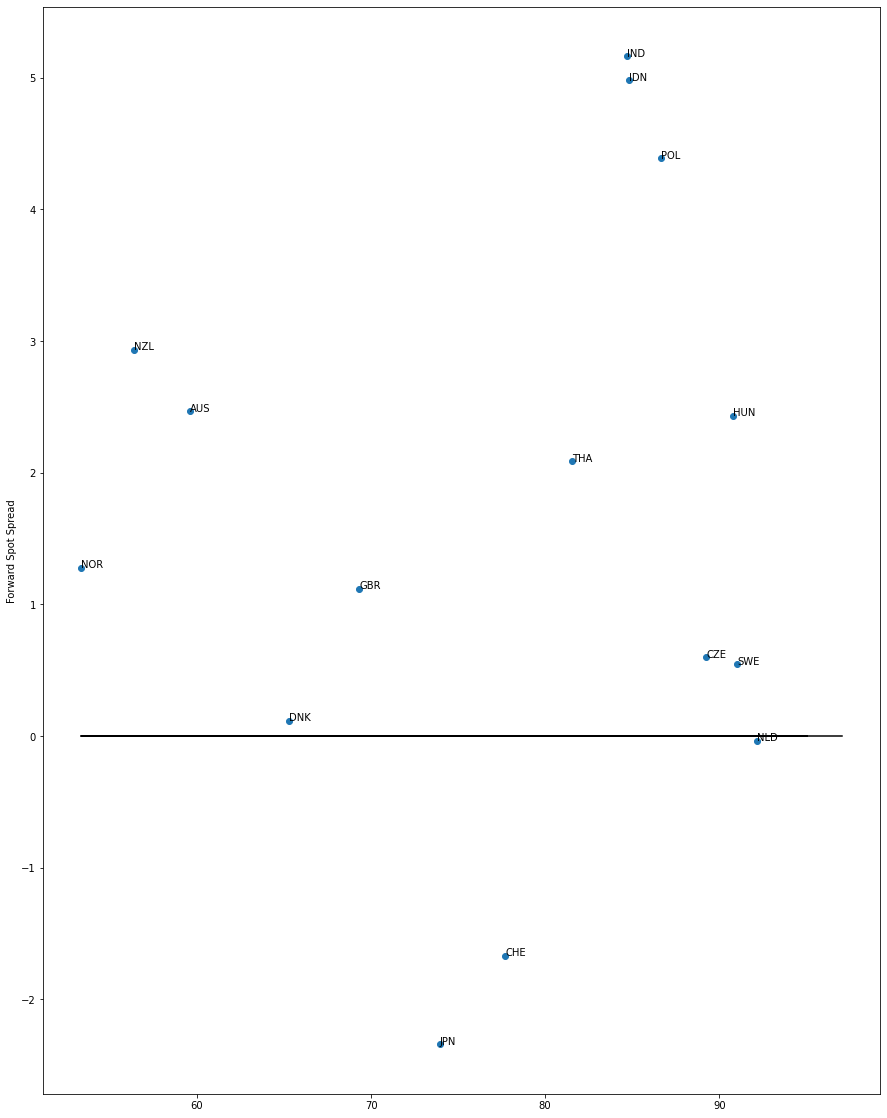

In [58]:
compressed['USD_EUR_share'] = compressed['Import USD_old']+compressed['Import EUR_old']
path_saveFig = os.path.abspath(os.path.join(os.getcwd(), '../../../..', 'Nicks Slides/Nick Julien Slides/figures')) + '/'
graphsSaveAppend = 'pure'
plotScatter('USD_EUR_share','forwardspread',compressed,"USD + EUR Share of Consumption","Forward Spot Spread")
plt.savefig(path_saveFig+'USD_EUR_fwd'+graphsSaveAppend+'.pdf')